DAY 14 — Random Forest

THE PROBLEM WITH DECISION TREES

Remember how Passenger 1, a first class female paying 100 got predicted as DIED? That's a classic symptom of a problem called overfitting.
* Underfitting — model is too simple, doesn't learn enough from data. Like a student who barely studied.
* Overfitting — model is too complex, memorizes training data. Like a student who memorized without understanding.
* Just right — model learns the actual patterns without memorizing noise.
>A single Decision Tree almost always overfits. Random Forest is the fix.

 TOPIC 1 — What is Random Forest?

Random Forest is beautifully simple in concept.
Instead of building ONE Decision Tree build 500 of them. Each tree is trained on a slightly different random sample of your data and uses a random subset of features. Each tree is slightly different, makes slightly different mistakes.
Then when predicting, ask all 500 trees. Each one votes. The majority vote wins.
* Tree 1:   SURVIVED
* Tree 2:   DIED
* Tree 3:   SURVIVED
* Tree 4:   SURVIVED
* Tree 5:   DIED
* ...
* Tree 500: SURVIVED

Majority vote → SURVIVED ✅
>This is called ensemble learning, combining many weak models to make one strong model.

TOPIC 2 — Building a Random Forest


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("Titanic.csv")

df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
X = df[["Pclass", "Age", "Sex", "Fare", "SibSp", "Parch"]] 
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create — n_estimators is number of trees
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train
model_rf.fit(X_train, y_train)

# Predict
rf_predictions = model_rf.predict(X_test)


That's it. Same fit() and predict() pattern. Just a different model class.

n_estimators=100 means 100 trees. More trees generally means better accuracy but slower training. 100 is a good starting point.

TOPIC 3 — Hyperparameters

When you create a model you can control its behavior through settings called hyperparameters.

In [31]:
model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)

* n_estimators — number of trees. More trees = more accurate but slower. Start with 100, try 200, 500.
* max_depth — how deep each tree can grow. Deeper = more complex = risk of overfitting. Limiting depth prevents individual trees from memorizing.
* min_samples_split — minimum number of samples needed to split a node. Higher value = simpler trees.
* max_features — number of features each tree considers at each split. Lower = more randomness = more diversity between trees.

TOPIC 4 — Cross Validation

Train test split gives you one accuracy number. But what if your random split happened to put all the easy cases in the test set? Your accuracy would look great but mean nothing.

Cross validation solves this by splitting your data multiple times and averaging the results:

In [32]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_rf, X, y, cv=5)
# cv=5 means 5 splits — called 5-fold cross validation

print(f"Individual scores: {scores}")
print(f"Mean accuracy: {scores.mean() * 100:.2f}%")
print(f"Standard deviation: {scores.std() * 100:.2f}%")

Individual scores: [0.78212291 0.82022472 0.88202247 0.82022472 0.84831461]
Mean accuracy: 83.06%
Standard deviation: 3.32%


With 5-fold cross validation it:

* Splits data into 5 equal parts
* Trains on 4 parts, tests on 1 part
* Repeats 5 times, each time using a different part as test
* Returns 5 accuracy scores — you take the mean

TOPIC 5 — Confusion Matrix
>A confusion matrix shows exactly where your model is making mistakes:

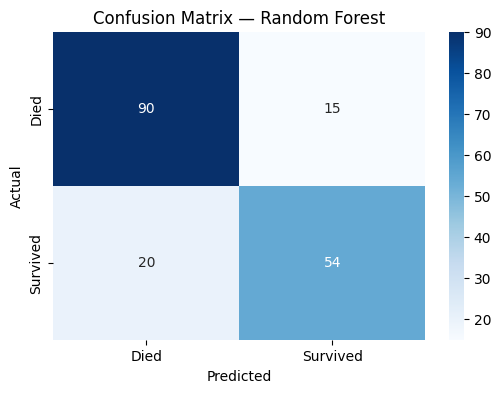

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, rf_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Died", "Survived"],
            yticklabels=["Died", "Survived"])
plt.title("Confusion Matrix — Random Forest")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


# Reading the confusion matrix:
#                 Predicted Died    Predicted Survived
# Actual Died         87                  18
# Actual Survived      30                 44
 

* 87 — correctly predicted died (True Negative)
* 44 — correctly predicted survived (True Positive)
* 18 — predicted survived but actually died (False Positive)
* 30 — predicted died but actually survived (False Negative)

False Negatives are the worst error here — you're telling someone they'll survive when they won't. In medical applications this kind of error analysis is literally life and death.


Task 1 — Build and Compare (25 mins)

Build a Random Forest and compare it directly against your Day 13 Decision Tree

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Decision Tree from Day 13
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)


print(f"Decision Tree Accuracy: {dt_acc * 100:.2f}%")
print(f"Random Forest Accuracy: {rf_acc * 100:.2f}%")
print(f"Improvement: {(rf_acc - dt_acc) * 100:.2f}%")

6
Decision Tree Accuracy: 75.42%
Random Forest Accuracy: 80.45%
Improvement: 5.03%


Task 2 — Tune the Model (20 mins)

In [35]:
configs = [
    {"n_estimators": 50,  "max_depth": 5},
    {"n_estimators": 100, "max_depth": 10},
    {"n_estimators": 200, "max_depth": None},  # None = unlimited depth
]

for config in configs:
    rf = RandomForestClassifier(random_state=42, **config)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print(f"n_estimators={config['n_estimators']}, max_depth={config['max_depth']}: {acc*100:.2f}%")


n_estimators=50, max_depth=5: 79.33%
n_estimators=100, max_depth=10: 79.89%
n_estimators=200, max_depth=None: 79.33%


the single train test split got lucky. With random_state=42 the 80/20 split happened to put slightly easier cases in the test set. Cross validation tests on 5 different splits and averages them so lucky splits and unlucky splits both get included. The average is more honest and usually slightly lower than the luckiest single split.

Task 3 — Cross Validation (15 mins)

In [36]:
from sklearn.model_selection import cross_val_score

best_rf = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(best_rf, X, y, cv=5)

print(f"Individual fold scores: {scores * 100}")
print(f"Mean accuracy: {scores.mean() * 100:.2f}%")
print(f"Std deviation: {scores.std() * 100:.2f}%")

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"single split Accuracy: {accuracy * 100:.2f}%")

# as we can see the single train split is higher than the mean cross validation score..
# it is because of the number of trees the single split having only one tree due to which only single accuracy is what we get,
# but in case of cross validation's mean score there are many more trees whose individual scores are different due to which mean is lower..

Individual fold scores: [77.09497207 81.46067416 87.07865169 78.65168539 84.83146067]
Mean accuracy: 81.82%
Std deviation: 3.72%
single split Accuracy: 75.42%


Task 4 — Confusion Matrix + Feature Importance (20 mins)

  Feature  Importance
2     Sex    0.323452
3    Fare    0.269112
1     Age    0.213756
0  Pclass    0.096887
4   SibSp    0.057324
5   Parch    0.039469
  Feature  Importance
2     Sex    0.308977
3    Fare    0.271238
1     Age    0.222803
0  Pclass    0.119203
4   SibSp    0.050848
5   Parch    0.026929


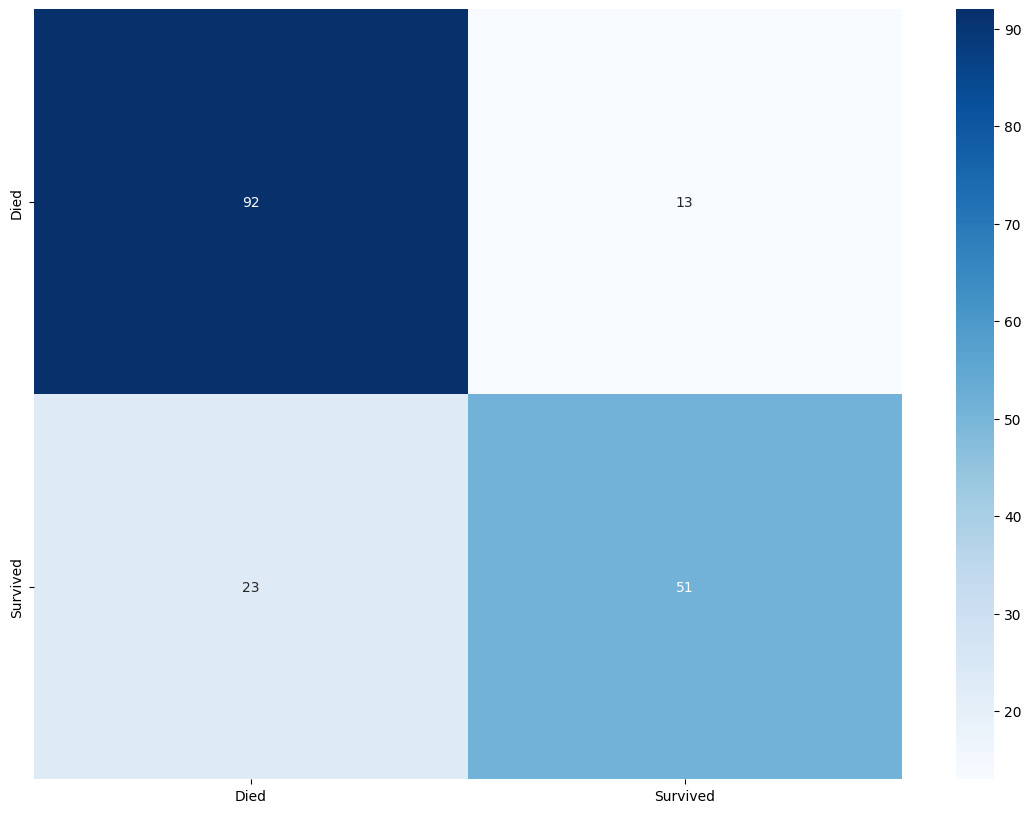

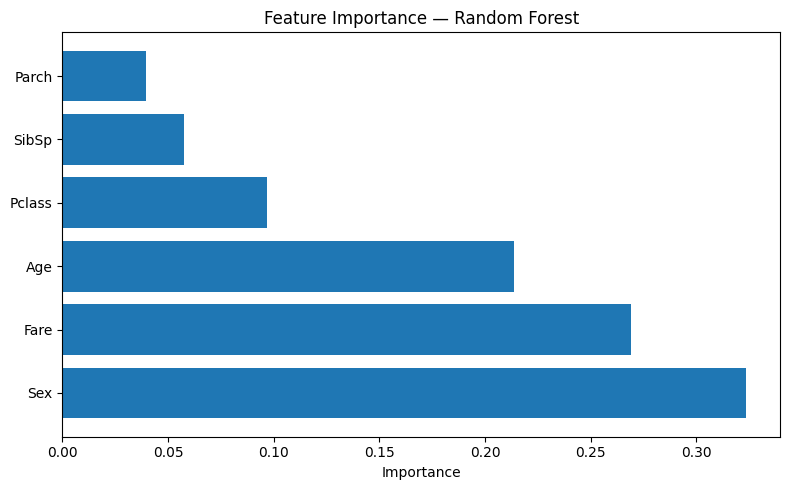

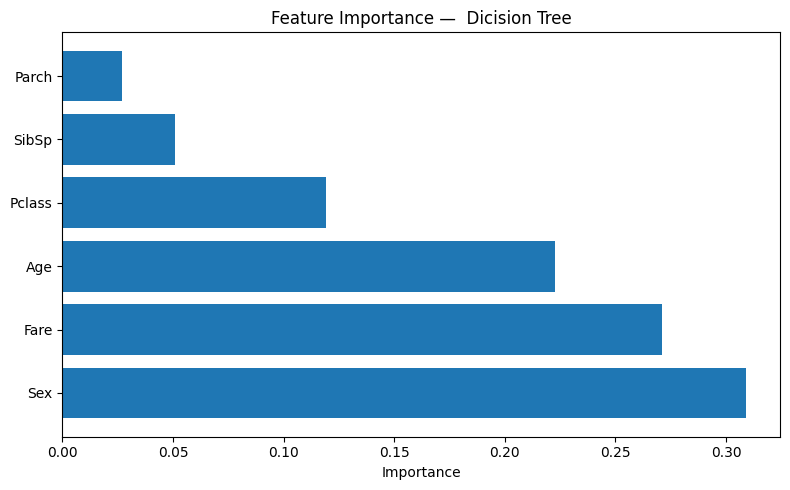

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)

rf.fit(X_train,y_train)
prediction = rf.predict(X_test)

cm = confusion_matrix(y_test, prediction)

plt.figure(figsize=(14,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Died", "Survived"],
            yticklabels=["Died", "Survived"])

importance_df = pd.DataFrame({
    "Feature": ["Pclass", "Age", "Sex", "Fare", "SibSp", "Parch"],
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

print(importance_df)

plt.figure(figsize=(8, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.title("Feature Importance — Random Forest")
plt.tight_layout()

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
prediction = dt.predict(X_test)

importance_dt = pd.DataFrame({"Feature": ["Pclass", "Age", "Sex", "Fare", "SibSp", "Parch"],
                              "Importance":dt.feature_importances_}).sort_values("Importance", ascending=False)

print(importance_dt)
plt.figure(figsize=(8, 5))
plt.barh(importance_dt["Feature"], importance_dt["Importance"])
plt.xlabel("Importance")
plt.title("Feature Importance —  Dicision Tree")
plt.tight_layout()
plt.show()
